

# Playing MsPacman with Reinforcement Learning


## Ayadi Aymen, Kaabachi Bayrem, Hojeily Woody, Ben Naceur Walid



In [15]:
# %load mspacman (1).py
import gym
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt
import os
import argparse

## Agent

In [16]:
class Agent():
    def __init__(self, action_size, weight_backup=None,
                 save_weight='./MsPacman_weight.h5', frames_per_state=8):
        self.weight_backup = weight_backup
        self.save_weight = save_weight
        self.memory = deque(maxlen=50000)

        self.observe = 100

        self.explore = 1e5
        self.INITIAL_EXPLORE = 0.1
        self.exploration_rate = self.INITIAL_EXPLORE
        self.exploration_min = 0.0001
        self.learning_rate = 1e-6
        self.gamma = .95

        self.action_size = action_size
        self.brain = self._build_model()
        self.env_features = 128  # 128 bytes of atari console's RAM
        self.frames = 0

    def _build_model(self):
        model = Sequential()
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        if self.weight_backup and os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min

        return model

    def save_model(self):
        self.brain.save_weights(self.save_weight)

    def act(self, state):
        if self.frames < 1000 or np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size):
        if len(self.memory) < self.observe:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
                u = self.brain.predict(x=next_state)
                target = reward + self.gamma * np.amax(u[0])
            target_f = self.brain.predict(state)
            target_f[0][action] = target
            self.brain.fit(state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate -= (self.INITIAL_EXPLORE -
                                      self.exploration_min)/self.explore


## Pacman Environment

In [17]:
class MsPacman:
    def __init__(self, weight_backup=None, frames_per_state=8):
        self.sample_batch_size = 32
        self.episodes = 2000
        self.env = gym.make('MsPacman-ram-v0')

        self.action_size = self.env.action_space.n
        self.fpstate = frames_per_state

        self.agent = Agent(self.action_size, weight_backup,
                           frames_per_state=frames_per_state)

    def run(self, render=False):
        try:
            plot = []
            max_plot = []
            avg_plot = []
            max = 0
            avg = 0
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = np.reshape(state, [1, self.agent.env_features])

                reward = 0
                acc_reward = 0
                done = False
                lives = 3
                while not done:
                    acc_reward += reward
                    self.agent.frames += 1

                    if render:
                        self.env.render()

                    action = self.agent.act(state)
                    next_state, reward, done, al_lives = self.env.step(action)

                    if al_lives['ale.lives'] < lives:
                        lives -= 1
                        reward -= 100

                    next_state = np.reshape(
                        next_state, [1, self.agent.env_features])

                    self.agent.remember(
                        state, action, reward, next_state, done)
                    state = next_state

                if acc_reward > max:
                    max = acc_reward
                avg = (avg * index_episode + acc_reward) / (index_episode + 1)
                plot.append(acc_reward)
                max_plot.append(max)
                avg_plot.append(avg)

                if index_episode % 100 == 0:
                    print("Episode {}# Score: {} - max: {} - average: {})".format(
                        index_episode, acc_reward, max, avg))

                self.agent.replay(self.sample_batch_size)

        finally:
            self.env.close()
            print('')
            plt.plot(plot)
            plt.savefig('score.png')
            plt.show()
            plt.plot(max_plot, label='Max Score')
            plt.plot(avg_plot, label='Average Score')
            plt.legend(framealpha=1, frameon=True)
            plt.savefig('score_avg_max.png')
            plt.show()
            self.agent.save_model()


# Running the program

Episode 0# Score: 40.0 - max: 40.0 - average: 40.0)



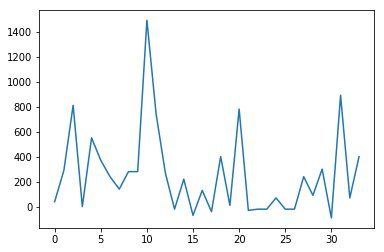

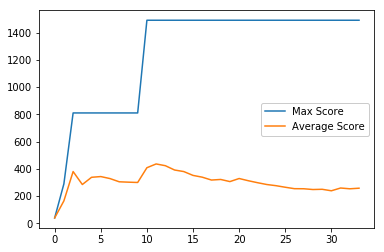

KeyboardInterrupt: 

In [18]:
if __name__ == '__main__':
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--pre-trained-weights', '-w', help='Use this to load trained weights.',
                        #default=None, const='./MsPacman_weight.h5', nargs='?')
    #parser.add_argument('--render', '-r', help='Use this to render the game in a gui.', type=bool,
                        #default=False, const=True, nargs='?')

    #args = parser.parse_args()

    mspacman = MsPacman()
    mspacman.run()
